# .::Preprocesamiento de dataset original:::......................................................................................................................................

In [75]:
import os
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from collections import Counter

In [76]:
DATASET_DIR = r"E:\DatasetRecon\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset"            # carpeta original con subcarpetas por clase
OUTPUT_DIR = "dataset_preprocessed"  # carpeta destino para los resultados
IMG_SIZE = 224                                # tamaño final (H,W)
RANDOM_STATE = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)
CATEGORIES = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
print("Categorías:", CATEGORIES)

Categorías: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


# Muestra de imagen por categoria


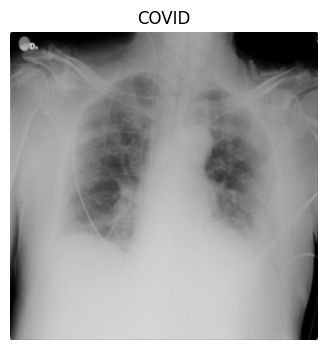

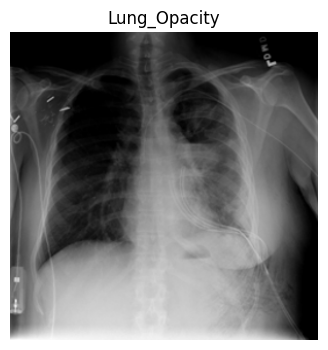

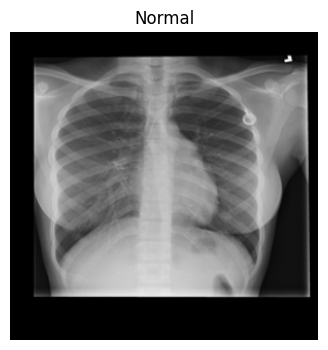

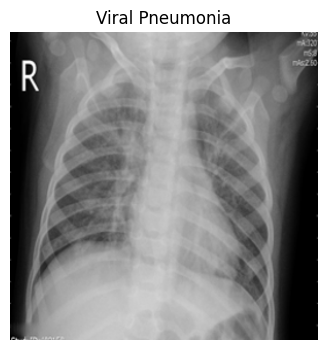

In [77]:
def show_samples_per_class(dataset_dir, categories, n=1):
    for c in categories:
        folder = os.path.join(dataset_dir, c)
        files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]
        if not files:
            continue
        for i in range(min(n, len(files))):
            img = cv2.imread(os.path.join(folder, files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4,4)); plt.imshow(img); plt.title(c); plt.axis('off'); plt.show()

show_samples_per_class(DATASET_DIR, CATEGORIES, n=1)

In [78]:
# Funciones para preprocesamiento
def resize_image(img, size=IMG_SIZE):
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

def crop_remove_borders(img, border_px=20):
    h, w = img.shape[:2]
    return img[border_px:h-border_px, border_px:w-border_px]

def apply_clahe_rgb(img):
    # convertir a LAB y aplicar CLAHE en L
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def apply_bilateral(img, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(img, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)

def normalize_to_uint8(img):
    # img float o uint8 -> aseguramos uint8 en 0..255
    if img.dtype == np.float32 or img.dtype == np.float64:
        img_scaled = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    else:
        img_scaled = img
    return img_scaled



# Pipeline para procesamiento sin filtro
#### Se remueven 20px a cada borde de la imagen
#### Se hace un rezise de la imagen a 224px
#### Se aplica un filtro CLAHE que aumenta los contrastes de la imagen

In [79]:
def pipeline_no_filter(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    # 1) recorte automático ROI
    #img = crop_by_largest_contour(img)
    # 2) eliminar bordes pequeños
    img = crop_remove_borders(img, border_px=8)
    # 3) aplicar CLAHE
    img = apply_clahe_rgb(img)
    # 4) redimensionar
    img = resize_image(img, IMG_SIZE)
    # 5) normalizar float32 [0,1] para further processing (no guardado)
    img_f = img.astype(np.float32) / 255.0
    return img_f

In [80]:
# Procesado sin filtro

OUT_RAW = os.path.join(OUTPUT_DIR, "raw_preproc")
os.makedirs(OUT_RAW, exist_ok=True)
for c in CATEGORIES:
    os.makedirs(os.path.join(OUT_RAW, c), exist_ok=True)

# Procesamiento (puede tardar, se hace una sola vez)
for c in CATEGORIES:
    input_folder = os.path.join(DATASET_DIR, c)
    for fname in tqdm(os.listdir(input_folder), desc=f"Procesando {c}"):
        src = os.path.join(input_folder, fname)
        try:
            img_raw = pipeline_no_filter(src)
            if img_raw is None: 
                continue
            # guardar como uint8
            out_path_raw = os.path.join(OUT_RAW, c, fname)
            cv2.imwrite(out_path_raw, cv2.cvtColor(normalize_to_uint8(img_raw), cv2.COLOR_RGB2BGR))
        except Exception as e:
            # log opcional: print("Error en", src, e)
            continue

print("Procesamiento finalizado. Carpetas:", OUT_RAW)

Procesando COVID:   0%|          | 0/3616 [00:00<?, ?it/s]

Procesando Viral Pneumonia: 100%|██████████| 1345/1345 [00:32<00:00, 41.92it/s]

Procesamiento finalizado. Carpetas: dataset_preprocessed\raw_preproc


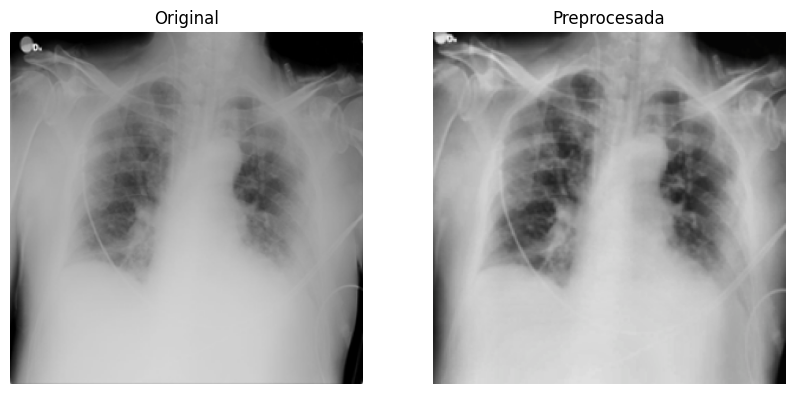

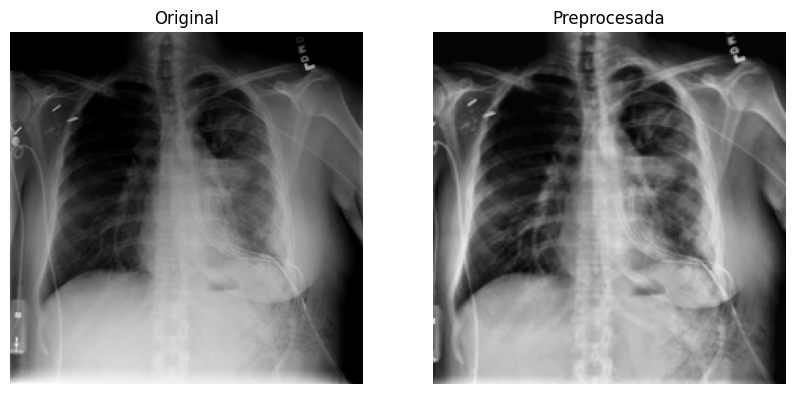

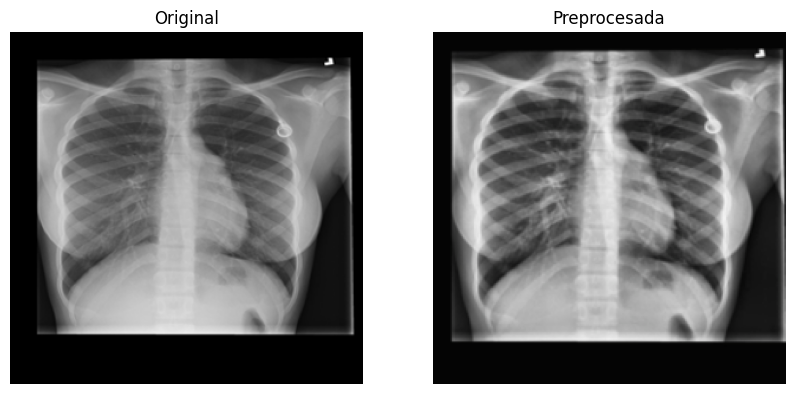

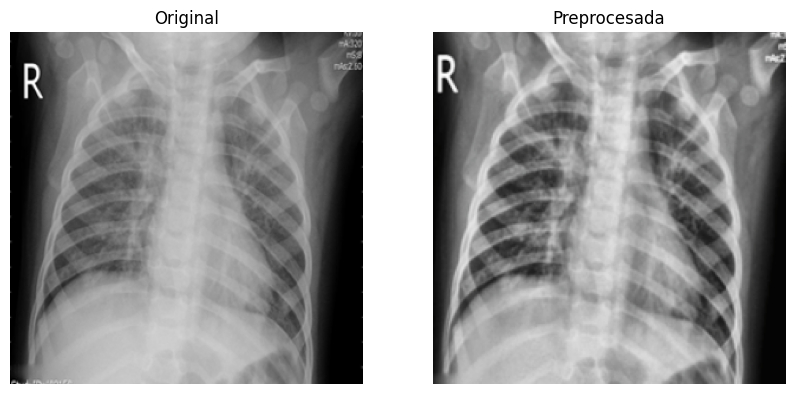

In [81]:
# Ejemplos de antes y despues de preprocesar
# COVID
img_covid_o = cv2.imread(os.path.join(DATASET_DIR, "COVID/COVID-1.png"))
img_covid_p = cv2.imread(os.path.join(OUT_RAW, "COVID/COVID-1.png"))

img_covid_o = cv2.cvtColor(img_covid_o, cv2.COLOR_BGR2RGB)
img_covid_p = cv2.cvtColor(img_covid_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_covid_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_covid_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

# Lung_Opacity

img_lung_o = cv2.imread(os.path.join(DATASET_DIR, "Lung_Opacity/Lung_Opacity-1.png"))
img_lung_p = cv2.imread(os.path.join(OUT_RAW, "Lung_Opacity/Lung_Opacity-1.png"))

img_lung_o = cv2.cvtColor(img_lung_o, cv2.COLOR_BGR2RGB)
img_lung_p = cv2.cvtColor(img_lung_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_lung_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_lung_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

# Normal

img_normal_o = cv2.imread(os.path.join(DATASET_DIR, "Normal/Normal-1.png"))
img_normal_p = cv2.imread(os.path.join(OUT_RAW, "Normal/Normal-1.png"))

img_normal_o = cv2.cvtColor(img_normal_o, cv2.COLOR_BGR2RGB)
img_normal_p = cv2.cvtColor(img_normal_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_normal_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_normal_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

# Viral Pneumonia

img_viral_o = cv2.imread(os.path.join(DATASET_DIR, "Viral Pneumonia/Viral Pneumonia-1.png"))
img_viral_p = cv2.imread(os.path.join(OUT_RAW, "Viral Pneumonia/Viral Pneumonia-1.png"))

img_viral_o = cv2.cvtColor(img_viral_o, cv2.COLOR_BGR2RGB)
img_viral_p = cv2.cvtColor(img_viral_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_viral_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_viral_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

# Balanceo de cantidades de imagenes por categoria

In [82]:
SOURCE_DIR = r"E:\Proyecto2Recon\dataset_preprocessed\raw_preproc"   # dataset ya preprocesado 


TARGET_PER_CLASS = 6000   # cantidad objetivo de imágenes por clase
IMG_SIZE = 224

print("Carpeta fuente:", SOURCE_DIR)


Carpeta fuente: E:\Proyecto2Recon\dataset_preprocessed\raw_preproc


In [86]:


# Crear imagenes para balanceo

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.9, 1.05)),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

def augment_and_save_image(src_path, dst_folder, n_aug=1):
    """Genera n_aug nuevas versiones de una imagen con pequeñas variaciones."""
    try:
        img = cv2.imread(src_path)
        if img is None:
            return
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil = Image.fromarray(img)

        for i in range(n_aug):
            aug_img = augmentation_transform(pil)
            aug_np = cv2.cvtColor(np.array(aug_img), cv2.COLOR_RGB2BGR)
            fname = os.path.splitext(os.path.basename(src_path))[0]
            new_name = f"{fname}_aug{i}.png"
            cv2.imwrite(os.path.join(dst_folder, new_name), aug_np)
    except Exception as e:
        print("Error en augmentación:", src_path, e)


for cat in CATEGORIES:
    src_folder = os.path.join(SOURCE_DIR, cat)
    dst_folder = os.path.join(SOURCE_DIR, cat)

    existing = len(os.listdir(src_folder))
    target = TARGET_PER_CLASS
    deficit = target - existing

    print(f"\nClase: {cat} — {existing} imágenes actuales — objetivo: {target}")

    if deficit > 0:
        print("Generando imagenes...")
        # Cantidad de veces que se deben aumentar las imágenes
        multiplier = max(1, int(np.ceil(deficit / existing)))
        all_files = os.listdir(src_folder)

        generated = 0
        with tqdm(total=deficit, desc=f"Augmentando {cat}") as pbar:
            while generated < deficit:
                for fname in all_files:
                    if generated >= deficit:
                        break
                    augment_and_save_image(os.path.join(src_folder, fname), dst_folder, n_aug=1)
                    generated += 1
                    pbar.update(1)
        existing = len(os.listdir(src_folder))
        deficit = target - existing
        print(f"Clase {cat}: generadas {generated} imágenes nuevas.")
    else:
        print(f"Clase {cat}: ya está balanceada o supera el objetivo.")


Clase: COVID — 6000 imágenes actuales — objetivo: 6000
Clase COVID: ya está balanceada o supera el objetivo.

Clase: Lung_Opacity — 6012 imágenes actuales — objetivo: 6000
Clase Lung_Opacity: ya está balanceada o supera el objetivo.

Clase: Normal — 10192 imágenes actuales — objetivo: 6000
Clase Normal: ya está balanceada o supera el objetivo.

Clase: Viral Pneumonia — 5900 imágenes actuales — objetivo: 6000
Generando imagenes...


Augmentando Viral Pneumonia: 100%|██████████| 100/100 [00:00<00:00, 202.83it/s]

Clase Viral Pneumonia: generadas 100 imágenes nuevas.


In [87]:
# Conteo final
def count_images(folder):
    counts = {}
    for c in CATEGORIES:
        cpath = os.path.join(folder, c)
        counts[c] = len([f for f in os.listdir(cpath) if os.path.isfile(os.path.join(cpath, f))])
    return counts

current_counts = count_images(SOURCE_DIR)
print("Conteo inicial de imágenes por clase:")
print(current_counts)

final_counts = count_images(SOURCE_DIR)
print("\nConteo final de imágenes por clase (dataset balanceado):")
for k,v in final_counts.items():
    print(f"{k}: {v}")
total_images = sum(final_counts.values())
print(f"\nTotal de imágenes en el dataset balanceado: {total_images}")

Conteo inicial de imágenes por clase:
{'COVID': 6000, 'Lung_Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 5900}

Conteo final de imágenes por clase (dataset balanceado):
COVID: 6000
Lung_Opacity: 6012
Normal: 10192
Viral Pneumonia: 5900

Total de imágenes en el dataset balanceado: 28104


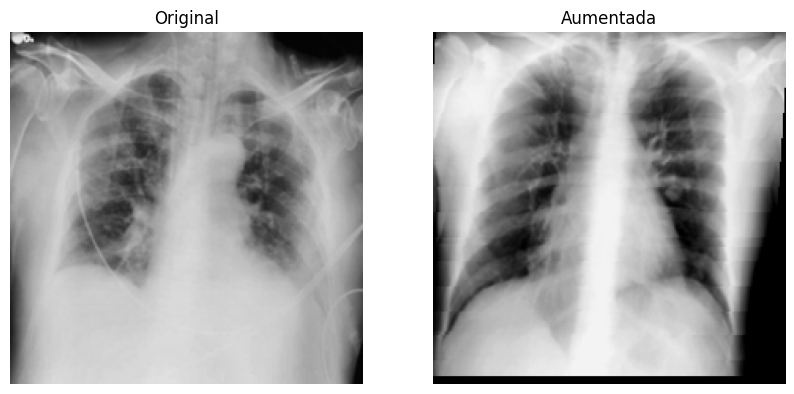

In [91]:
sample_class = [c for c in CATEGORIES if "aug" not in c][0]
folder = os.path.join(SOURCE_DIR, sample_class)
files = [f for f in os.listdir(folder) if f.endswith(".png")]
originals = [f for f in files if "aug" not in f]
augmented = [f for f in files if "aug" in f]

if originals and augmented:
    img_o = cv2.imread(os.path.join(folder, originals[0]))
    img_a = cv2.imread(os.path.join(folder, augmented[0]))
    img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
    img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img_o); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img_a); plt.title("Aumentada"); plt.axis('off')
    plt.show()

else:
    print("No se encontraron imágenes aumentadas para mostrar.")

# Pipeline para aplicar filtro bilateral

In [92]:
def pipeline_with_bilateral(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("none")
        return None
    # aplicar bilateral ANTES de resize (más consistente)
    img_f = apply_bilateral(img, d=9, sigmaColor=75, sigmaSpace=75)
    return img_f

In [93]:
RAW_DIR = os.path.join(OUTPUT_DIR, "raw_preproc")
OUT_FILTERED = os.path.join(OUTPUT_DIR, "filtered_preproc")
os.makedirs(OUT_FILTERED, exist_ok=True)
for c in CATEGORIES:
    os.makedirs(os.path.join(OUT_FILTERED, c), exist_ok=True)

# Procesamiento (puede tardar, se hace una sola vez)
for c in CATEGORIES:
    input_folder = os.path.join(RAW_DIR, c)
    for fname in tqdm(os.listdir(input_folder), desc=f"Procesando {c}"):
        src = os.path.join(input_folder, fname)
        try:
            img_filt = pipeline_with_bilateral(src)
            out_path_filt = os.path.join(OUT_FILTERED, c, fname)
            cv2.imwrite(out_path_filt, cv2.cvtColor(normalize_to_uint8(img_filt), cv2.COLOR_RGB2BGR))
        except Exception as e:
            # log opcional: print("Error en", src, e)
            continue

print("Procesamiento finalizado. Carpetas:", OUT_FILTERED)

Procesando Viral Pneumonia: 100%|██████████| 5900/5900 [00:50<00:00, 116.56it/s]

Procesamiento finalizado. Carpetas: dataset_preprocessed\filtered_preproc
